# Corrective RAG

![alt text](download.png)

In [1]:
import os
os.environ["TAVILY_API_KEY"] = "Your Tavily API Key Here"
os.environ['GROQ_API_KEY'] = "Your Groq API KEY Here"
model="llama3-70b-8192"
from langchain_groq import ChatGroq
llm=ChatGroq(model_name=model)

In [2]:
from langchain.embeddings import HuggingFaceEmbeddings
import torch
# Load E5-Large-v2 model (excellent performance for semantic search)
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"},
    encode_kwargs={"normalize_embeddings": True}  # helps cosine similarity
)

# Embed a query (remember to use "query:" prefix as per E5 format)
query_embedding = embeddings.embed_query("query: what is an LLM agent?")
print(f"Embedding vector length: {len(query_embedding)}")


/tmp/ipykernel_53656/2749822407.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding vector length: 1024


In [3]:
from langchain_community.document_loaders import WebBaseLoader
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25)
doc_splits=text_splitter.split_documents(docs_list)

In [5]:
from langchain_community.vectorstores import Chroma
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [6]:
retriever=vectorstore.as_retriever()
retriever.invoke("what is agent and prompt?")

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'language': 'en', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'title': "Prompt Engineering | Lil'Log"}, page_content="Prompt Engineering | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\

In [7]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [8]:
tools=[retriever_tool]
from langgraph.prebuilt import ToolNode
retriever_node=ToolNode(tools)
llm_with_tool=llm.bind_tools(tools)

In [9]:
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage

tavily = TavilySearchResults()

def web_crawler_node(state: AgentState) -> AgentState:
    print("--web crawler call--")

    # Accept full query even if multi-line
    query = state["messages"][-1].content
    
    print("📥 Full query content:")
    print(query)
    print("🧵 Type of query:", type(query))

    # Perform real-time web search
    try:
        results = tavily.invoke({"query": query.strip()})
    except Exception as e:
        content = f"❌ Tavily search failed: {e}"
    else:
        # Format results
        if not results:
            content = "⚠️ No relevant information found on the web."
        elif isinstance(results, list):
            content = "\n\n".join([
                f"- {r.get('title', 'No Title')}: {r.get('content', '')}\n{r.get('url', '')}"
                for r in results
            ])
        else:
            content = str(results)

    # Create AIMessage response
    updated_messages = [AIMessage(content=f"Tavily Search Results:\n{content}")]

    return {"messages": updated_messages}


In [11]:
def pretty_print_agent_state(state: dict):
    print("\n🔍 AgentState Message Trace:")
    print("=" * 50)
    
    messages = state.get("messages", [])
    
    if not messages:
        print("🚫 No messages found in AgentState.")
        return
    
    for idx, msg in enumerate(messages):
        role = type(msg).__name__.replace("Message", "")  # HumanMessage → Human
        content = msg.content.strip() if hasattr(msg, "content") else "No content"
        
        print(f"📨 Message {idx + 1} | Role: {role}")
        print("-" * 50)
        print(content)
        print("=" * 50)


In [12]:
from langchain_core.prompts import PromptTemplate
def LLM_Decision_Maker(state:AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    message=state["messages"]
    pretty_print_agent_state(state)
    last_message=message[-1]
    
    question=last_message.content
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [13]:
from langchain_core.pydantic_v1 import BaseModel, Field
class grade(BaseModel):
    binary_score:str=Field(description="Relvance score 'yes' or 'no'")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
from typing import Literal
def grade_documents(state:AgentState)->Literal["Output Generator", "Query Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
     
    chain=prompt|llm_with_structure_op
     
     
    message=state['messages']
    pretty_print_agent_state(state)
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result=chain.invoke({"question": question, "context": docs})
    
    score=scored_result.binary_score
     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [15]:
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()
print(type(hub.pull("rlm/rag-prompt")))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
<class 'langchain_core.prompts.chat.ChatPromptTemplate'>


In [16]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage

def generate(state: AgentState):
    print("----RAG OUTPUT GENERATE----")

    message = state["messages"]
    question = message[0].content
    pretty_print_agent_state(state)
    last_message = message[-1]
    docs = last_message.content

    # Properly define a PromptTemplate
    prompt = PromptTemplate.from_template("""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved RAG output or web search results to answer the question.
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

    Question: {question}  
    Context: {context}  
    Answer:
    """)

    # Create the RAG chain
    rag_chain = prompt | llm

    # Invoke the chain
    response = rag_chain.invoke({"context": docs, "question": question})
    print("Output Generator Response")
    print(response)
    return {"messages": [response]}


In [17]:
def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    message=state["messages"]
    print(message)
    question=message[0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: 
                    Also dont write any comments and other things only and only write the improved question""")
       ]

    response=llm.invoke(input)
    
    return {"messages": [response]}
    

In [18]:
from langgraph.graph import END, StateGraph, START
workflow=StateGraph(AgentState)
workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewrite)
workflow.add_node("Web Crawler",web_crawler_node)

In [19]:
workflow.add_edge(START,"LLM Decision Maker")
from langgraph.prebuilt import tools_condition
workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {"tools":"Vector Retriever",
                                END:END
                                })

workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {"generator":"Output Generator",
                                "rewriter":"Query Rewriter"
                                })
workflow.add_edge("Output Generator",END)
workflow.add_edge("Query Rewriter","Web Crawler")
workflow.add_edge("Web Crawler","Output Generator")
app=workflow.compile()

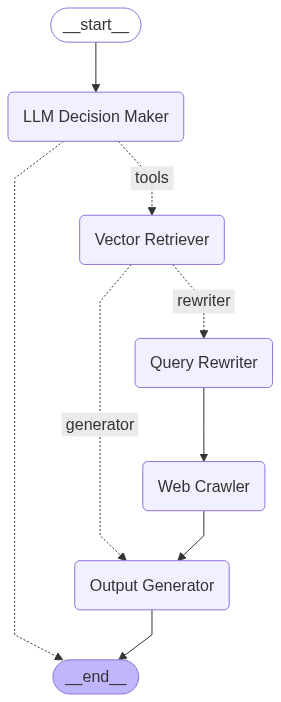

In [20]:
app

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"]})

----CALL LLM_DECISION_MAKE----

🔍 AgentState Message Trace:
📨 Message 1 | Role: Human
--------------------------------------------------
what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?
----CALLING GRADE FOR CHECKING RELEVANCY----

🔍 AgentState Message Trace:
📨 Message 1 | Role: Human
--------------------------------------------------
what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?
📨 Message 2 | Role: AI
--------------------------------------------------

📨 Message 3 | Role: Tool
--------------------------------------------------
LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ

Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |

{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='3e7942db-c108-4845-b35e-970b52efa089'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bsbwc9gdn', 'function': {'arguments': '{"query":"LLM Powered Autonomous Agents planning and reflection and prompt engineering in terms of agents and LangChain"}', 'name': 'retriever_blog_post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 998, 'total_tokens': 1090, 'completion_time': 0.262857143, 'prompt_time': 0.032364724, 'queue_time': 0.207876446, 'total_time': 0.295221867}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7ebe362f-15d3-46f5-8ad0-09764c6cf113-0', tool_calls=[{'name': 'retriever_blog_post', 'args': {'que

In [23]:
app.invoke({"messages":["Hello How r u?"]})

----CALL LLM_DECISION_MAKE----

🔍 AgentState Message Trace:
📨 Message 1 | Role: Human
--------------------------------------------------
Hello How r u?


{'messages': [HumanMessage(content='Hello How r u?', additional_kwargs={}, response_metadata={}, id='84d70c21-f857-44aa-b367-52cc8552b91f'),
  AIMessage(content="I'm doing well, thank you for asking! How about you?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 978, 'total_tokens': 993, 'completion_time': 0.080074082, 'prompt_time': 0.039673442, 'queue_time': 0.200616189, 'total_time': 0.119747524}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--a3469bfc-4708-431e-829b-a919691f94c0-0', usage_metadata={'input_tokens': 978, 'output_tokens': 15, 'total_tokens': 993})]}